In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 

library(Seurat)
library(Signac)
library(ggplot2)
library(hdf5r)
library(EnsDb.Mmusculus.v79)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Loading required package: ensembldb

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    

In [3]:
out_prefix="/data/proj/GCB_MB/bcd_CT/single-cell/results/"
modality="ATAC"
feature="peaks"
data_10x="/data/proj/GCB_MB/bcd_CT/single-cell/results/scATAC_10x/download/8k_mouse_cortex_ATACv1p1_nextgem_Chromium_X_filtered_peak_bc_matrix.h5"
metadata="/data/proj/GCB_MB/bcd_CT/single-cell/results/scATAC_10x/download/8k_mouse_cortex_ATACv1p1_nextgem_Chromium_X_singlecell.csv"
fragments="/data/proj/GCB_MB/bcd_CT/single-cell/results/scATAC_10x/download/8k_mouse_cortex_ATACv1p1_nextgem_Chromium_X_fragments.tsv.gz"
allen_RNA="/data/proj/GCB_MB/bcd_CT/single-cell/results/scATAC_10x/download/allen_brain.rds"
out_seurat = "/data/proj/GCB_MB/bcd_CT/single-cell/results/scATAC_10x/seurat/Seurat_object.Rds"


  

In [4]:
%%R -i data_10x -i metadata -i fragments -i allen_RNA -i out_seurat
counts   <- Read10X_h5(data_10x)
metadata <- read.csv(metadata)
fragments <- fragments

In [5]:
%%R 
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'mm10',
  fragments = fragments
)

seurat <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)



R[write to console]: Computing hash

R[write to console]: Checking for 
R[write to console]: 7749
R[write to console]:  cell barcodes
R[write to console]: 



In [6]:
%%R
annotations <-  suppressWarnings(GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79,verbose = F))


In [7]:
%%R
seqlevelsStyle(annotations) <- 'UCSC'
Annotation(seurat) <- annotations


In [8]:
%%R
# compute nucleosome signal score per cell
seurat <- NucleosomeSignal(object = seurat)

# compute TSS enrichment score per cell
seurat <- TSSEnrichment(object = seurat, fast = FALSE)

# add blacklist ratio and fraction of reads in peaks
seurat$pct_reads_in_peaks <- seurat$peak_region_fragments / seurat$passed_filters * 100
seurat$blacklist_ratio <- seurat$blacklist_region_fragments / seurat$peak_region_fragments

R[write to console]: Found 
R[write to console]: 7749
R[write to console]:  cell barcodes
R[write to console]: 

Done Processing le]: 
R[write to console]: 1
R[write to console]:  million lines
Done Processing le]: 
R[write to console]: 2
R[write to console]:  million lines
Done Processing le]: 
R[write to console]: 3
R[write to console]:  million lines
Done Processing le]: 
R[write to console]: 4
R[write to console]:  million lines
Done Processing le]: 
R[write to console]: 5
R[write to console]:  million lines
Done Processing le]: 
R[write to console]: 6
R[write to console]:  million lines
Done Processing le]: 
R[write to console]: 7
R[write to console]:  million lines
Done Processing le]: 
R[write to console]: 8
R[write to console]:  million lines
Done Processing le]: 
R[write to console]: 9
R[write to console]:  million lines
                                                  
Done Processing le]: 
R[write to console]: 10
R[write to console]:  million lines
Done Processing le]: 
R[w

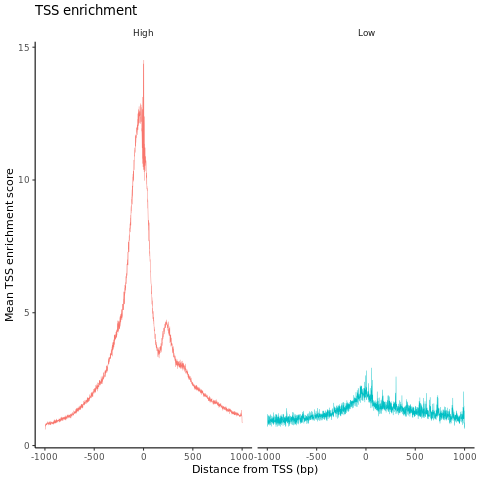

In [9]:
%%R
seurat$high.tss <- ifelse(seurat$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(seurat, group.by = 'high.tss') + NoLegend()

In [10]:
%%R
seurat <- RunTFIDF(seurat)
seurat <- FindTopFeatures(seurat, min.cutoff = 'q0')
seurat <- RunSVD(seurat)


R[write to console]: Performing TF-IDF normalization

R[write to console]: Running SVD

R[write to console]: Scaling cell embeddings



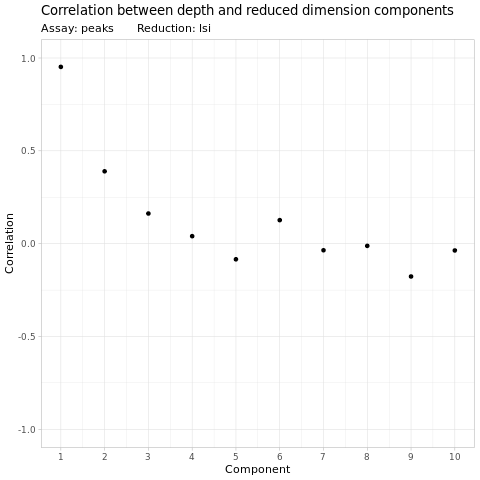

In [11]:
%%R
DepthCor(seurat)


In [12]:
%%R
seurat <- RunUMAP(object = seurat, reduction = 'lsi', dims = 2:30,verbose = FALSE)
seurat <- FindNeighbors(object = seurat, reduction = 'lsi', dims = 2:30,verbose = FALSE)
seurat <- FindClusters(object = seurat, verbose = FALSE, algorithm = 3)


R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session



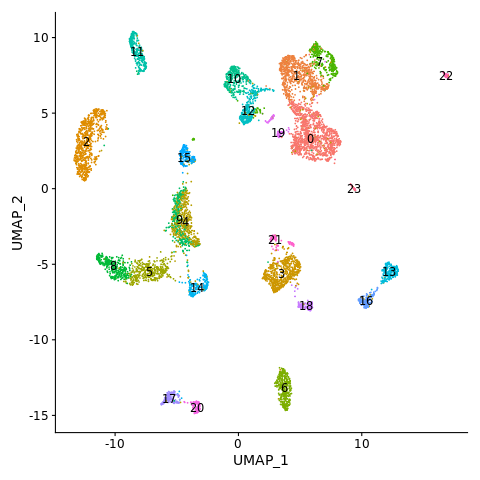

In [13]:
%%R
DimPlot(object = seurat, label = TRUE) + NoLegend()


In [14]:
%%R
gene.activities <- GeneActivity(seurat)


R[write to console]: Extracting gene coordinates

R[write to console]: Extracting reads overlapping genomic regions



  |                                                  | 0 % ~calculating   |+++++                                             | 9 % ~05m 40s       |++++++++++                                        | 18% ~05m 19s       |++++++++++++++                                    | 27% ~05m 20s       |+++++++++++++++++++                               | 36% ~04m 58s       |+++++++++++++++++++++++                           | 45% ~04m 28s       |++++++++++++++++++++++++++++                      | 55% ~03m 47s       |++++++++++++++++++++++++++++++++                  | 64% ~03m 11s       |+++++++++++++++++++++++++++++++++++++             | 73% ~02m 21s       |+++++++++++++++++++++++++++++++++++++++++         | 82% ~01m 34s       |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~49s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=09m 07s


In [15]:
%%R
seurat[['RNA']] <- CreateAssayObject(counts = gene.activities)
seurat <- NormalizeData(
  object = seurat,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(seurat$nCount_RNA)
)

R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

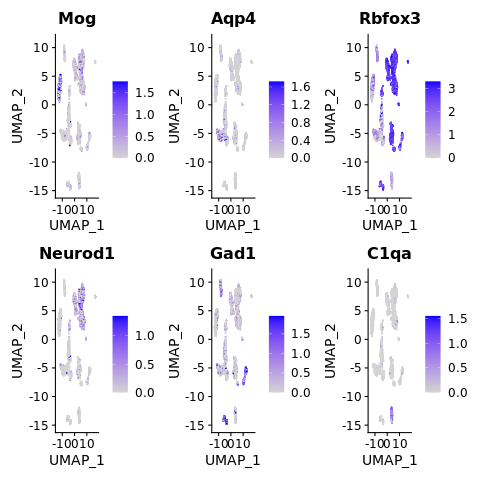

In [16]:
%%R
DefaultAssay(seurat) <- 'RNA'

options(repr.plot.width=20, repr.plot.height=10)

FeaturePlot(
  object = seurat,
  features = c('Mog','Aqp4','Rbfox3','Neurod1','Gad1','C1qa'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)


In [17]:
%%R
allen_rna <- readRDS(allen_RNA)
allen_rna <- FindVariableFeatures(
  object = allen_rna,
  nfeatures = 5000
)

R[write to console]: Calculating gene variances
R[write to console]: 

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]

In [18]:
%%R
transfer.anchors <- FindTransferAnchors(
  reference = allen_rna,
  query = seurat,
  reduction = 'cca',
  dims = 1:40
)

predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = allen_rna$subclass,
  weight.reduction = seurat[['lsi']],
  dims = 2:30
)



R[write to console]: Warning:
R[write to console]:  npcs is smaller than the largest value requested by the dims parameter.
Setting npcs to 40 and continuing.

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10963 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4449 anchors

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R

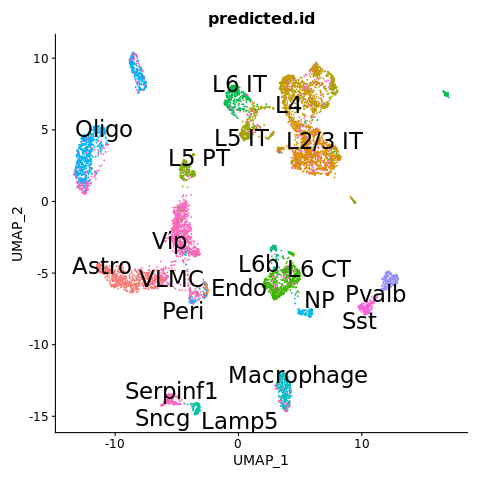

In [19]:
%%R
seurat <- AddMetaData(object = seurat, metadata = predicted.labels)
DimPlot(seurat,group.by='predicted.id',label=TRUE,label.size = 8,repel=TRUE) + NoLegend()

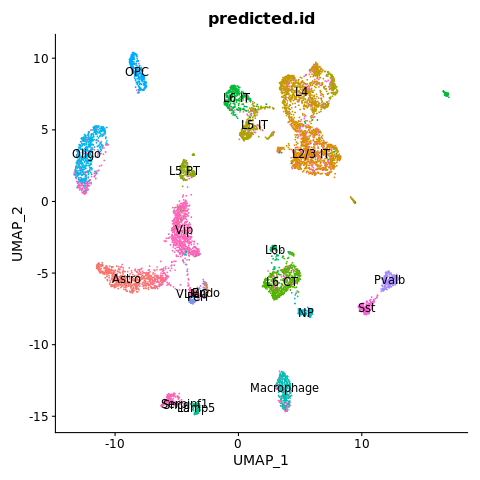

In [20]:
%%R
seurat$predicted.id[seurat$seurat_clusters == 11] <- 'OPC'

DimPlot(seurat,group.by='predicted.id',label=TRUE) + NoLegend()


In [ ]:
%%R
# Fix predicted.id /
seurat$predicted.id <- gsub(x = seurat$predicted.id,pattern='/',replacement = '_')


In [21]:
%%R
saveRDS(object = seurat,file = out_seurat)

R[write to console]: Error in saveRDS(object = seurat, file = out_seurat) : 
  object 'out_seurat' not found

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]),  :
R[write to console]: 
 
R[write to console]:  'giveCsparse' has been deprecated; setting 'repr = "T"' for you

R[write to console]: 2: 
R[write to console]: In CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks",  :
R[write to console]: 
 
R[write to console]:  Some cells in meta.data not present in provided counts matrix.




Error in saveRDS(object = seurat, file = out_seurat) : 
  object 'out_seurat' not found


RInterpreterError: Failed to parse and evaluate line 'saveRDS(object = seurat,file = out_seurat)\n'.
R error message: "Error in saveRDS(object = seurat, file = out_seurat) : \n  object 'out_seurat' not found"